# T07: Naive Bayes and Cross-validation

TA: WANG Zhiwei, HKUST

Date: October 25, 2022

## Naive Bayes Classification

Recall that the classifcation implied by Bayes Theorem
$$\Pr(y=k|X=x)=\frac{\pi_kf_k(x)}{\sum_{l=1}^K\pi_lf_l(x)},$$
where $X\in\mathbb{R}^p, y\in\mathbb{R}^n$.

- For __LDA__, we have 
$$X|y=k\sim\mathcal{N}(\mu_k,\Sigma),\ \text{then} \ f_k(x)=\frac{1}{(2\pi)^{p/2}|\Sigma|^{1/2}}\exp(-\frac{1}{2}(x-\mu_k)^T\Sigma^{-1}(x-\mu_k)).$$

    - Assign an observation $X=x$ to the class $k$ for which $\Pr(y=k|X=x)>\Pr(y=k'|X=x)$, where $k'\neq k$.

    - This is equivalent to assigning an observation $X=x$ to the class $k$ for which 
    $$\delta_k(x)=x^T\Sigma^{-1}\mu_k-\frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k+\log\pi_k$$
    is largest.

- For __QDA__, we have
$$X|y=k\sim\mathcal{N}(\mu_k,\color{red}{\Sigma_k}),\ \text{then} \ f_k(x)=\frac{1}{(2\pi)^{p/2}|\color{red}{\Sigma_k}|^{1/2}}\exp(-\frac{1}{2}(x-\mu_k)^T\color{red}{\Sigma_k}^{-1}(x-\mu_k)).$$
It assigns an observation $X=x$ to the class for which 
$$\delta_k(x)=\color{red}{-\frac{1}{2}x^T\Sigma_k^{-1}x}+x^T\color{red}{\Sigma_k}^{-1}\mu_k-\frac{1}{2}\mu_k^T\color{red}{\Sigma_k}^{-1}\mu_k-\color{red}{\frac{1}{2}\log|\Sigma_k|}+\log\pi_k$$
is largest.

We can consider an even simpler model, the __Naive Bayes__,  which assumes __conditional independence__ between $X_j$'s:
$$X_j|y=k\sim\mathcal{N}(\mu_{jk},\sigma_{jk}^2),$$then$$f_k(x)=\prod_{j=1}^p\mathcal{N}(\mu_{jk},\sigma_{jk}^2)=\frac{1}{(2\pi)^{p/2}\color{red}{\prod_{j=1}^p\sigma_{jk}}}\exp(\sum_{j=1}^p-\frac{(x_j-\mu_{jk})^2}{2\color{red}{\sigma_{jk}^2}}).$$
- Equivalent to setting all the off-diagonal elements of $\Sigma$ in LDA to zero
- Assign an observation $X=x$ to the class $k$ for which $\Pr(y=k|X=x)>\Pr(y=k'|X=x)$, where $k'\neq k$
- This is equivalent to assigning an observation $X=x$ to the class $k$library(MASS)
library(klaR)
library(ggplot2)
library(mvtnorm)
options(warn=-1) for which 
$$\delta_k(x)=-\frac{1}{2}\sum_{j}\frac{x_j^Tx_j}{\sigma_{jk}^2} + \sum_{j}x_j\frac{\mu_{jk}}{\sigma_{jk}^2}-\frac{1}{2}\frac{\mu_{jk}^2}{\sigma_{jk}^2}+\log\pi_k$$
is largest.

We are going to compare the performance of Naive Bayes and QDA using simulation data

In [1]:
library(MASS)
library(klaR)
library(reshape2)
library(ggplot2)
library(mvtnorm)
options(warn = -1)

In [2]:
set.seed(20221025)

ntrain <- 200
ntest <- 500
n <- ntrain + ntest
idx_train <- 1:ntrain
idx_test <- (ntrain + 1):n

p <- 15 # Number of predictors
beta <- rnorm(p) # Coeficients

trial <- 30 # Number of trials

Sig <- 0.9^(abs(outer(1:p, 1:p, FUN = "-"))) # Covariance matrix, outer product function
diag(Sig) <- 1
Sig

1.0000000,0.9000000,0.8100000,0.7290000,0.6561000,0.5904900,0.5314410,0.4782969,0.4304672,0.3874205,0.3486784,0.3138106,0.2824295,0.2541866,0.2287679
0.9000000,1.0000000,0.9000000,0.8100000,0.7290000,0.6561000,0.5904900,0.5314410,0.4782969,0.4304672,0.3874205,0.3486784,0.3138106,0.2824295,0.2541866
0.8100000,0.9000000,1.0000000,0.9000000,0.8100000,0.7290000,0.6561000,0.5904900,0.5314410,0.4782969,0.4304672,0.3874205,0.3486784,0.3138106,0.2824295
0.7290000,0.8100000,0.9000000,1.0000000,0.9000000,0.8100000,0.7290000,0.6561000,0.5904900,0.5314410,0.4782969,0.4304672,0.3874205,0.3486784,0.3138106
0.6561000,0.7290000,0.8100000,0.9000000,1.0000000,0.9000000,0.8100000,0.7290000,0.6561000,0.5904900,0.5314410,0.4782969,0.4304672,0.3874205,0.3486784
0.5904900,0.6561000,0.7290000,0.8100000,0.9000000,1.0000000,0.9000000,0.8100000,0.7290000,0.6561000,0.5904900,0.5314410,0.4782969,0.4304672,0.3874205
0.5314410,0.5904900,0.6561000,0.7290000,0.8100000,0.9000000,1.0000000,0.9000000,0.8100000,0.7290000,0.6561000,0.5904900,0.5314410,0.4782969,0.4304672
0.4782969,0.5314410,0.5904900,0.6561000,0.7290000,0.8100000,0.9000000,1.0000000,0.9000000,0.8100000,0.7290000,0.6561000,0.5904900,0.5314410,0.4782969
0.4304672,0.4782969,0.5314410,0.5904900,0.6561000,0.7290000,0.8100000,0.9000000,1.0000000,0.9000000,0.8100000,0.7290000,0.6561000,0.5904900,0.5314410
0.3874205,0.4304672,0.4782969,0.5314410,0.5904900,0.6561000,0.7290000,0.8100000,0.9000000,1.0000000,0.9000000,0.8100000,0.7290000,0.6561000,0.5904900
0.3486784,0.3874205,0.4304672,0.4782969,0.5314410,0.5904900,0.6561000,0.7290000,0.8100000,0.9000000,1.0000000,0.9000000,0.8100000,0.7290000,0.6561000


In [3]:
err <- matrix(0, trial, 2) # Error matrix

for (i in 1:trial) {
    X <- rmvnorm(n, mean = rep(0, p), sigma = Sig)
    t <- X %*% beta
    t <- t # + sqrt(c(var(t))*2)*rnorm(n)
    prob <- 1 / (1 + exp(-t))
    y <- rbinom(n, 1, prob)
    dat <- data.frame(X, y = factor(y))

    fit_qda <- qda(y ~ ., dat, subset = idx_train)
    pred_qda <- predict(fit_qda, dat[idx_test, ])
    err_qda <- -sum(y[idx_test] * log(pred_qda$posterior[, 2]) + (1 - y[idx_test]) * log(pred_qda$posterior[, 1])) / ntest
    err[i, 1] <- err_qda

    fit_nb <- NaiveBayes(y ~ ., dat, subset = idx_train)
    pred_nb <- predict(fit_nb, dat[idx_test, ])
    err_nb <- -sum(y[idx_test] * log(pred_nb$posterior[, 2]) + (1 - y[idx_test]) * log(pred_nb$posterior[, 1])) / ntest
    err[i, 2] <- err_nb
}

err <- data.frame(1:trial, err)
colnames(err) <- c("Trial", "QDA", "Naive Bayes")
head(err)

,Trial,QDA,Naive Bayes
,<int>,<dbl>,<dbl>
1,1,0.7547595,2.125185
2,2,0.9304498,1.409790
3,3,0.8363672,1.669203
4,4,0.7136972,1.513631
5,5,0.8841076,2.150612
6,6,0.8146990,1.868257


In [4]:
err <- melt(
    data = err,
    id.vars = "Trial",
    variable.name = "Method",
    value.name = "Error"
)
head(err)

,Trial,Method,Error
,<int>,<fct>,<dbl>
1,1,QDA,0.7547595
2,2,QDA,0.9304498
3,3,QDA,0.8363672
4,4,QDA,0.7136972
5,5,QDA,0.8841076
6,6,QDA,0.8146990


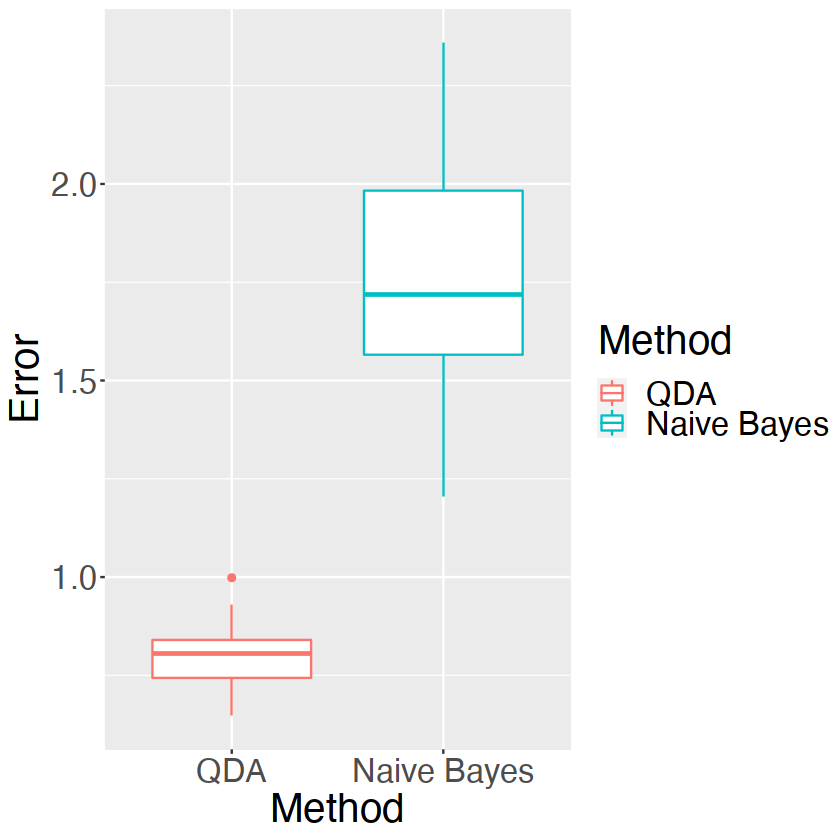

In [5]:
ggplot(data = err, aes(x = Method, y = Error, color = Method)) +
    geom_boxplot() +
    theme(
        text = element_text(size = 24)
    )

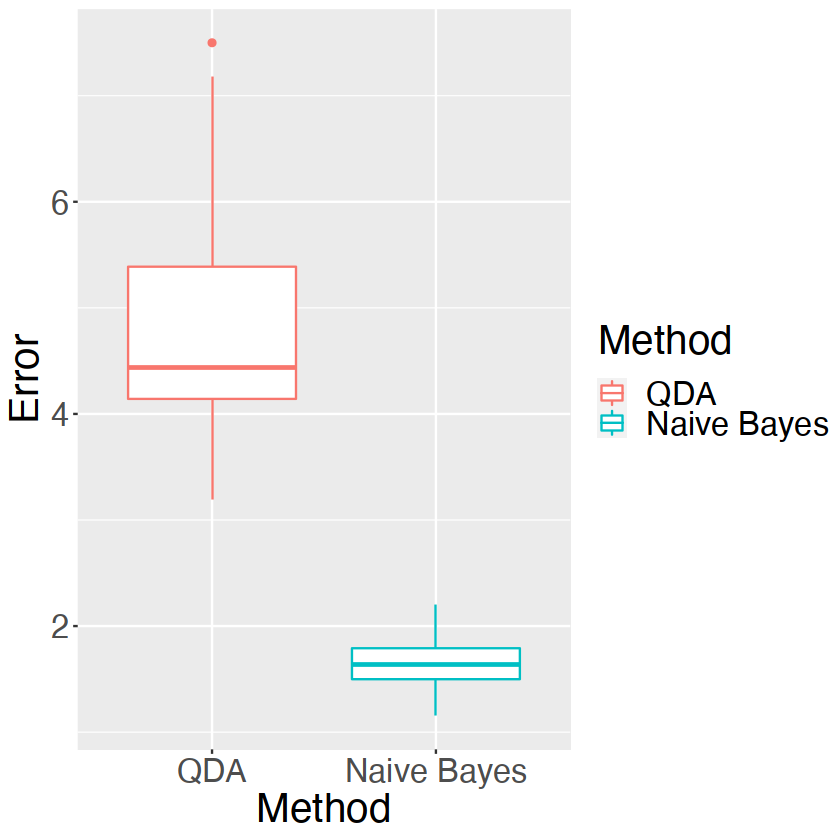

In [6]:
ntrain <- 200
ntest <- 500
n <- ntrain + ntest
idx_train <- 1:ntrain
idx_test <- (ntrain + 1):n

p <- 50
beta <- rnorm(p)

trial <- 30
err <- matrix(0, trial, 2)

Sig <- 0.9^(abs(outer(1:p, 1:p, "-")))
diag(Sig) <- 1

err <- matrix(0, trial, 2) # Error matrix

for (i in 1:trial) {
    X <- rmvnorm(n, mean = rep(0, p), sigma = Sig)
    t <- X %*% beta
    t <- t # + sqrt(c(var(t))*2)*rnorm(n)
    prob <- 1 / (1 + exp(-t))
    y <- rbinom(n, 1, prob)
    dat <- data.frame(X, y = factor(y))

    fit_qda <- qda(y ~ ., dat, subset = idx_train)
    pred_qda <- predict(fit_qda, dat[idx_test, ])
    err_qda <- -sum(y[idx_test] * log(pred_qda$posterior[, 2]) + (1 - y[idx_test]) * log(pred_qda$posterior[, 1])) / ntest
    err[i, 1] <- err_qda

    fit_nb <- NaiveBayes(y ~ ., dat, subset = idx_train)
    pred_nb <- predict(fit_nb, dat[idx_test, ])
    err_nb <- -sum(y[idx_test] * log(pred_nb$posterior[, 2]) + (1 - y[idx_test]) * log(pred_nb$posterior[, 1])) / ntest
    err[i, 2] <- err_nb
}

err <- data.frame(1:trial, err)
colnames(err) <- c("Trial", "QDA", "Naive Bayes")
err <- melt(
    data = err,
    id.vars = "Trial",
    variable.name = "Method",
    value.name = "Error"
)

ggplot(data = err, aes(x = Method, y = Error, color = Method)) +
    geom_boxplot() +
    theme(
        text = element_text(size = 24)
    )

Short summary of __bias-variance tradeoff__

- QDA performs well when the sample size is large.
- Naive Bayes can outperforms QDA with small sample size even with the violence of assumption.

Try to think about it!

## Cross-Validation

In application, dividing the data into training and test sets may be a waste of information.
To fully use the whole dataset, we can apply the cross-validation strategy.

- Randomly partition the sample into $k$ equal-sized subsamples.
- Of the $k$ subsamples, a single subsample is retained as the validation data for testing the model, and the remaining $k − 1 $subsamples are used as training data.
- The cross-validation process is then repeated $k$ times, with each of the $k$ subsamples used exactly once as the validation data. 
- The $k$ results can then be averaged to produce a single estimation.
- All observations are used for both training and validation, and each observation is used for validation exactly once.
- 5 or 10 folds are usually used.

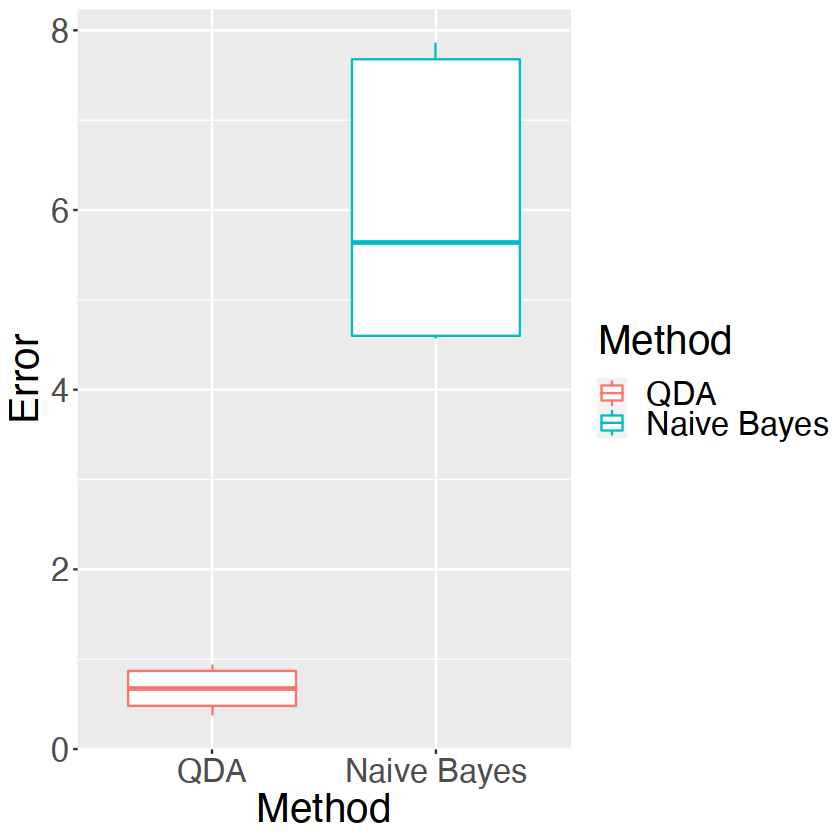

In [7]:
n <- 200
nfolds <- 10

p <- 15
beta <- rnorm(p)

Sig <- 0.9^(abs(outer(1:p, 1:p, "-")))
diag(Sig) <- 1

X <- rmvnorm(n, mean = rep(0, p), sigma = Sig)
t <- X %*% beta
t <- t # + sqrt(c(var(t))*2)*rnorm(n)
prob <- 1 / (1 + exp(-t))
y <- rbinom(n, 1, prob)
dat <- data.frame(X, y = factor(y))

dat_idx <- sample(1:n, n, replace = FALSE)
cv_err <- matrix(0, nfolds, 2)
for (i in 1:nfolds) {
    idx_test <- dat_idx[((i - 1) * n / nfolds + 1):(i * n / nfolds)]

    fit_qda <- qda(y ~ ., dat, subset = -idx_test)
    pred_qda <- predict(fit_qda, dat[idx_test, ])
    err_qda <- -sum(y[idx_test] * log(pred_qda$posterior[, 2]) + (1 - y[idx_test]) * log(pred_qda$posterior[, 1])) / (n / nfolds)
    cv_err[i, 1] <- err_qda

    fit_nb <- NaiveBayes(y ~ ., dat, subset = -idx_test)
    pred_nb <- predict(fit_nb, dat[1, ])
    err_nb <- -sum(y[idx_test] * log(pred_nb$posterior[, 2]) + (1 - y[idx_test]) * log(pred_nb$posterior[, 1])) / (n / nfolds)
    cv_err[i, 2] <- err_nb
}

cv_err <- data.frame(1:trial, cv_err)
colnames(cv_err) <- c("Trial", "QDA", "Naive Bayes")
cv_err <- melt(
    data = cv_err,
    id.vars = "Trial",
    variable.name = "Method",
    value.name = "Error"
)

ggplot(data = cv_err, aes(x = Method, y = Error, color = Method)) +
    geom_boxplot() +
    theme(
        text = element_text(size = 24)
    )

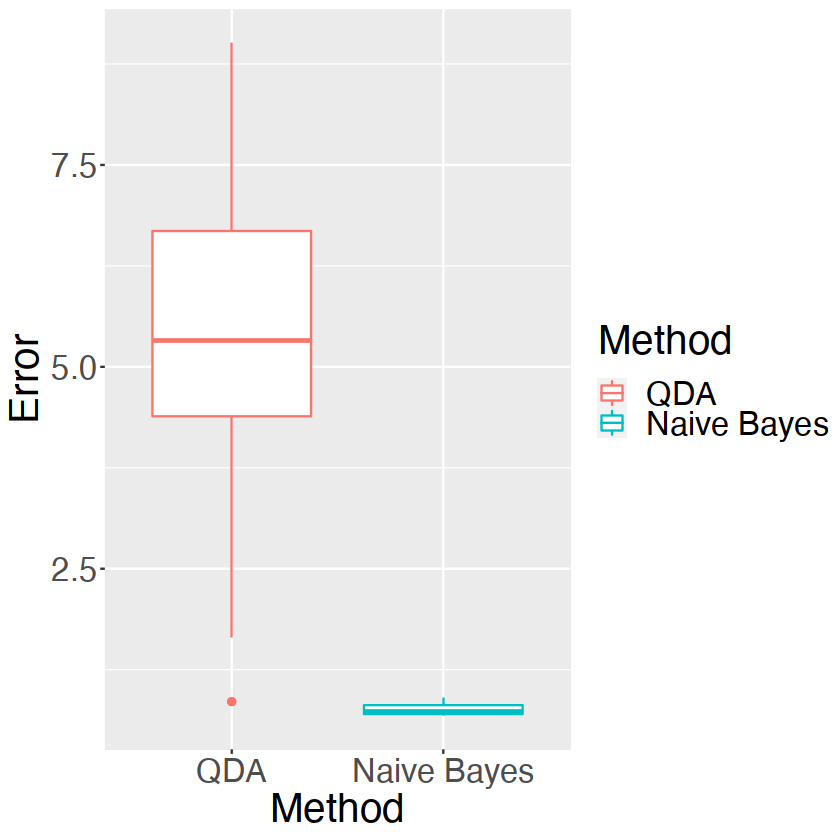

In [8]:
n <- 200
nfolds <- 10

p <- 50
beta <- rnorm(p)

Sig <- 0.9^(abs(outer(1:p, 1:p, "-")))
diag(Sig) <- 1

X <- rmvnorm(n, mean = rep(0, p), sigma = Sig)
t <- X %*% beta
t <- t # + sqrt(c(var(t))*2)*rnorm(n)
prob <- 1 / (1 + exp(-t))
y <- rbinom(n, 1, prob)
dat <- data.frame(X, y = factor(y))

dat_idx <- sample(1:n, n, replace = FALSE)
cv_err <- matrix(0, nfolds, 2)
for (i in 1:nfolds) {
    idx_test <- dat_idx[((i - 1) * n / nfolds + 1):(i * n / nfolds)]

    fit_qda <- qda(y ~ ., dat, subset = -idx_test)
    pred_qda <- predict(fit_qda, dat[idx_test, ])
    err_qda <- -sum(y[idx_test] * log(pred_qda$posterior[, 2]) + (1 - y[idx_test]) * log(pred_qda$posterior[, 1])) / (n / nfolds)
    cv_err[i, 1] <- err_qda

    fit_nb <- NaiveBayes(y ~ ., dat, subset = -idx_test)
    pred_nb <- predict(fit_nb, dat[1, ])
    err_nb <- -sum(y[idx_test] * log(pred_nb$posterior[, 2]) + (1 - y[idx_test]) * log(pred_nb$posterior[, 1])) / (n / nfolds)
    cv_err[i, 2] <- err_nb
}

cv_err <- data.frame(1:trial, cv_err)
colnames(cv_err) <- c("Trial", "QDA", "Naive Bayes")
cv_err <- melt(
    data = cv_err,
    id.vars = "Trial",
    variable.name = "Method",
    value.name = "Error"
)

ggplot(data = cv_err, aes(x = Method, y = Error, color = Method)) +
    geom_boxplot() +
    theme(
        text = element_text(size = 24)
    )